In [84]:
# Import(s)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [85]:
# Common variables
rad_to_deg = 180. / np.pi
nb_bins = 50
var = 'azimuth'
vmin, vmax = {
    'zenith':  (0,     np.pi * rad_to_deg),
    'azimuth': (0, 2 * np.pi * rad_to_deg),
}[var]
results_dir = "/groups/icecube/asogaard/gnn/results/von_mises-fisher_test/dev_level7_noise_muon_nu_classification_pass2_fixedRetro_v3/"
path_new = results_dir + f"dynedge_{var}/results.csv"
path_leg = results_dir + f"dynedge_{var}_legacy/results.csv"

In [86]:
# Utility method(s)
def wrap_to_minus_180_to_180(x):
    if x > 180:
        return x - 360.
    elif x < -180:
        return x + 360.
    else:
        return x

In [87]:
# Load new results
df_new = pd.read_csv(path_new, index_col=0)
df_new['truth'] = rad_to_deg * df_new[var]
df_new['pred'] = rad_to_deg * df_new[f"{var}_pred"]
df_new['sigma'] = rad_to_deg * 1./np.sqrt(df_new[f'{var}_kappa'])
df_new['residual'] = df_new.pred - df_new.truth
if var == 'azimuth':
    df_new.loc[df_new.pred < 0, 'pred'] = df_new.loc[df_new.pred < 0, 'pred'] + 360.
    df_new['residual'] = df_new.apply(lambda row: wrap_to_minus_180_to_180(row.residual), axis=1)
df_new['pull'] = df_new.residual / df_new.sigma
df_new.head()

,azimuth_pred,azimuth_kappa,event_no,energy,azimuth,truth,pred,sigma,residual,pull
0,2.810002,1.391108,34270388,25.195690,3.618952,207.350693,161.001255,48.578292,-46.349438,-0.954118
1,0.546938,1.331275,57933506,14.451158,1.895271,108.591047,31.337222,49.657953,-77.253825,-1.555719
2,5.779996,1.568874,31662171,19.290771,0.250358,14.344476,331.169376,45.743409,-43.175100,-0.943854
3,3.193939,1.957762,23689459,53.034725,3.957137,226.727243,182.999208,40.948943,-43.728036,-1.067867
4,0.888027,0.328073,10539253,26.428728,5.975599,342.376620,50.880179,100.031695,68.503559,0.684819


In [88]:
# Load legacy results
df_leg = pd.read_csv(path_leg, index_col=0)
df_leg['truth'] = rad_to_deg * df_leg[var]
df_leg['pred'] = rad_to_deg * df_leg[f"{var}_pred"]
df_leg['sigma'] = rad_to_deg * np.sqrt(df_leg[f'{var}_var'])
df_leg['residual'] = df_leg.pred - df_leg.truth
if var == 'azimuth':
    df_leg.loc[df_leg.pred < 0, 'pred'] = df_leg.loc[df_leg.pred < 0, 'pred'] + 360.
    df_leg['residual'] = df_leg.residual.apply(wrap_to_minus_180_to_180)
df_leg['pull'] = df_leg.residual / df_leg.sigma
df_leg.head()

,azimuth_pred,azimuth_var,event_no,azimuth,truth,pred,sigma,residual,pull
0,1.447901,0.159023,5301736,1.397253,80.056688,82.958605,22.848224,2.901917,0.127008
1,-1.363042,0.099306,42217846,5.747718,329.320000,281.903417,18.055495,-47.416583,-2.626158
2,1.511628,0.297803,112062,0.255649,14.647609,86.609905,31.267075,71.962296,2.301536
3,-2.446742,0.054431,84211420,3.752505,215.002676,219.812033,13.367306,4.809357,0.359785
4,0.034387,0.243713,44923687,5.853769,335.396275,1.970210,28.285361,26.573935,0.939494


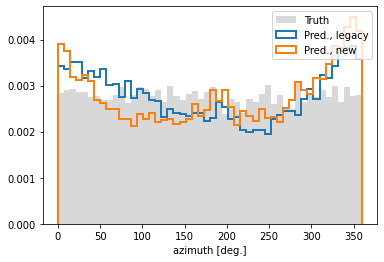

In [89]:
# Distribution
bins = np.linspace(vmin, vmax, nb_bins + 1)
plt.hist(df_leg.truth, bins=bins, density=1, alpha=0.3, color='gray', label=f'Truth')
plt.hist(df_leg.pred,  bins=bins, density=1, histtype='step', lw=2, label='Pred., legacy')
plt.hist(df_new.pred,  bins=bins, density=1, histtype='step', lw=2, label='Pred., new')
plt.xlabel(f"{var} [deg.]")
plt.legend()

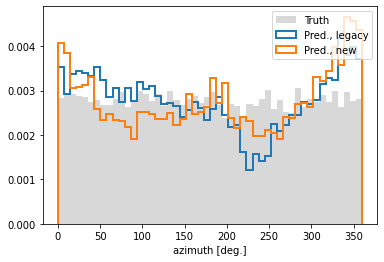

In [91]:
# Distribution (sliced in sigma)
percentile = 50.
threshold_sigma_leg = np.percentile(df_leg.sigma, percentile)
threshold_sigma_new = np.percentile(df_new.sigma, percentile)

df_leg_precise = df_leg.query(f"sigma < {threshold_sigma_leg}")
df_new_precise = df_new.query(f"sigma < {threshold_sigma_new}")

bins = np.linspace(vmin, vmax, nb_bins + 1)
plt.hist(df_leg.truth,        bins=bins, density=1, alpha=0.3, color='gray', label=f'Truth')
plt.hist(df_leg_precise.pred, bins=bins, density=1, histtype='step', lw=2, label='Pred., legacy')
plt.hist(df_new_precise.pred, bins=bins, density=1, histtype='step', lw=2, label='Pred., new')
plt.xlabel(f"{var} [deg.]")
plt.legend()

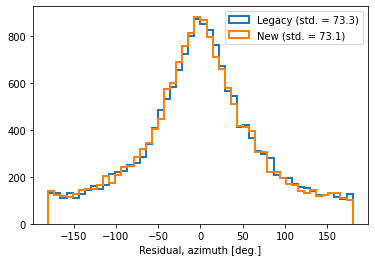

In [92]:
# Residual plot
xmin, xmax = -180, 180
bins = np.linspace(xmin, xmax, nb_bins + 1)
plt.hist(np.clip(df_leg.residual, xmin, xmax), bins=bins, histtype='step', lw=2, label=f'Legacy (std. = {df_leg.residual.std():.1f})')
plt.hist(np.clip(df_new.residual, xmin, xmax), bins=bins, histtype='step', lw=2, label=f'New (std. = {df_new.residual.std():.1f})')
plt.xlabel(f"Residual, {var} [deg.]")
plt.legend()

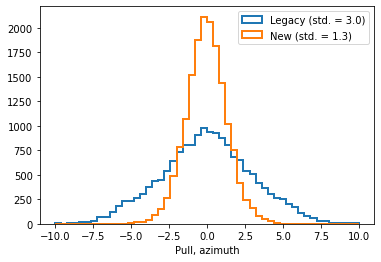

In [93]:
# Pull plot
bins = np.linspace(-10, 10, 50 + 1)
plt.hist(df_leg.pull, bins=bins, histtype='step', lw=2, label=f'Legacy (std. = {df_leg.pull.std():.1f})')
plt.hist(df_new.pull, bins=bins, histtype='step', lw=2, label=f'New (std. = {df_new.pull.std():.1f})')
plt.xlabel(f"Pull, {var}")
plt.legend()